In [1]:
from utils import *
from matplotlib import pyplot as plt

In [2]:
#High level todos: 
# - Alternative clustering approaches. (Same plot function with either cluster param that overrides rounding, or additional plots?)
# - Exception handling in the stratified approaches (oversampling in the proportional one )
# - Batching... 

In [3]:
from sklearn.cluster import KMeans

def cluster(f,n_clusters):
    if len(np.array(f).shape) == 1:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit([[i] for i in f])
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(f)
    return kmeans.labels_

    

def parse(strat_strat):
    if strat_strat.split("_")[0] == "round":
        return lambda f: round_strata(f,int(strat_strat.split("_")[-1]))
    elif strat_strat == "id":
        return lambda f: f 
    elif strat_strat.split("_")[0] == "kmeans":
        return lambda f: cluster(f,int(strat_strat.split("_")[-1]))
    
    

In [4]:
from matplotlib import pyplot as plt
def plot(f,y,ax,title,ns=[33,100,330,1000],k=1000,wr=False,plot_PPI=True,
         strat = ["round_6"],adaptive = ["round_6","round_16"],linestyles=["-","--",":"]
        ):
    base = []
    if plot_PPI:
        ppi = []
    
    strat = {key :[] for key in strat}
    adaptive = {key :[] for key in adaptive}
    for n in ns:
        base.append(baseline(f,y,n=n,k=k,with_replacement=wr))
        if plot_PPI:
            ppi.append(ppi_k(f,y,n=n,k=k,with_replacement=wr))
        for key in strat.keys():
            strat[key].append(simple_strat_k(parse(key)(f),y,n=n,k=k,with_replacement=wr))
        for key in adaptive.keys():
            adaptive[key].append(adaptive_strat_k(parse(key)(f),y,n=n,k=k,with_replacement=wr))

    ax.plot(ns,base,color="black") 
    if plot_PPI:
        ax.plot(ns,ppi,color="green")
    
    for i,key in enumerate(strat.keys()):
        ax.plot(ns,strat[key],color="orange",linestyle=linestyles[i])
        
    for i,key in enumerate(adaptive.keys()):    
        ax.plot(ns,adaptive[key],color="red",linestyle=linestyles[i])

    ax.set_title(model)
    ax.set_ylim(0,None)

    

# Pseudolabels/LLM Judge (LLama 405B)

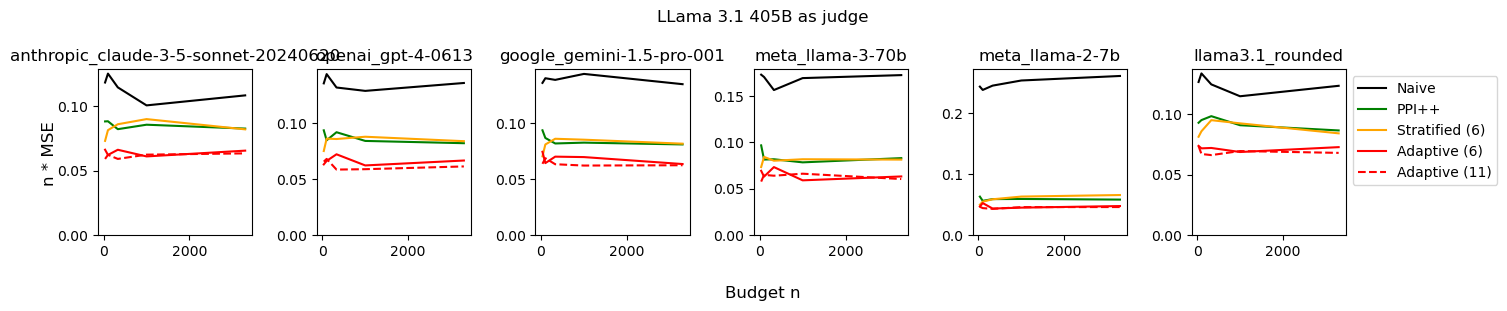

In [5]:
fig,axes = plt.subplots(1,6,figsize=(15,3))

models = ["anthropic_claude-3-5-sonnet-20240620","openai_gpt-4-0613","google_gemini-1.5-pro-001","meta_llama-3-70b","meta_llama-2-7b","llama3.1_rounded"]

for i,model in enumerate(models):
    f,y = make_predictions_judge(model)
    plot(f,y,axes[i],model,k=1000,ns=[33,100,330,1000,3300],strat=["round_6"],adaptive = ["round_6","round_11"],wr=True)
    
plt.suptitle("LLama 3.1 405B as judge")    
plt.legend(["Naive","PPI++","Stratified (6)","Adaptive (6)","Adaptive (11)"],bbox_to_anchor=(1,1))
fig.supxlabel("Budget n")
fig.supylabel("n * MSE")

fig.tight_layout()

plt.show()

# Datapoint Difficulty (LLama 405B answer entropy)

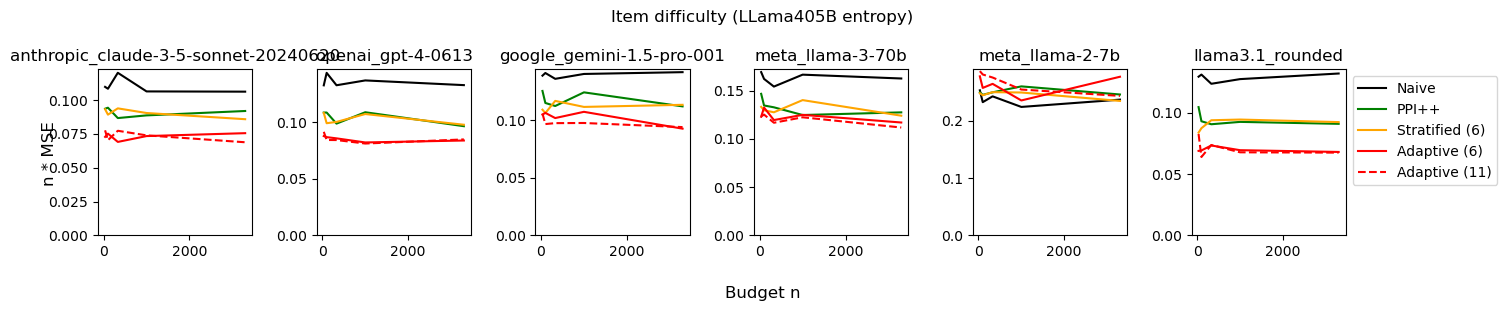

In [8]:
fig,axes = plt.subplots(1,6,figsize=(15,3))

models = ["anthropic_claude-3-5-sonnet-20240620","openai_gpt-4-0613","google_gemini-1.5-pro-001","meta_llama-3-70b","meta_llama-2-7b","llama3.1_rounded"]

for i,model in enumerate(models):
    f,y = make_predictions_judge_unc(model)
    plot(f,y,axes[i],model,k=1000,ns=[33,100,330,1000,3300],strat=["round_6"],adaptive = ["round_6","round_11"],wr=True)
    
plt.suptitle("Item difficulty (LLama405B entropy)")    
plt.legend(["Naive","PPI++","Stratified (6)","Adaptive (6)","Adaptive (11)"],bbox_to_anchor=(1,1))
fig.supxlabel("Budget n")
fig.supylabel("n * MSE")

fig.tight_layout()

plt.show()

# Datapoint Difficulty (Historical Means)

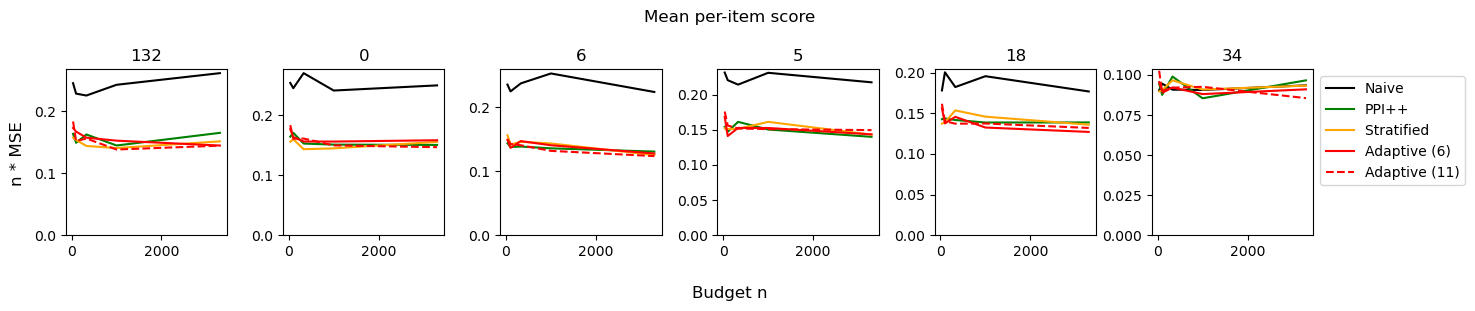

In [10]:
fig,axes = plt.subplots(1,6,figsize=(15,3))

models = [132,0,6,5,18,34] #Best to worse with roughly equally spaced models in between

for i,model in enumerate(models):
    f,y = make_predictions_mean_mmlu_pro(model)
    plot(f,y,axes[i],model,k=1000,ns=[33,100,330,1000,3300],strat=["round_6"],adaptive = ["round_6","round_11"],wr=True)
    
    
plt.suptitle("Mean per-item score")    
plt.legend(["Naive","PPI++","Stratified ","Adaptive (6)", "Adaptive (11)"],bbox_to_anchor=(1,1))
fig.supxlabel("Budget n")
fig.supylabel("n * MSE")

fig.tight_layout()

plt.show()

In [8]:
np.eye(3).shape

(3, 3)

0.24062489362365255 0.1812845777504568 0.16473050353933072
0.24888371147684193 0.20033148424433256 0.18674899758874672
0.23825428290516065 0.20178370284323768 0.18817271043909686
0.21735298844040013 0.1916611707912601 0.1764221281119678
0.1837040222085078 0.1637786462296782 0.14586719101645465
0.09204131955742136 0.0835051495263995 0.0608582434689115


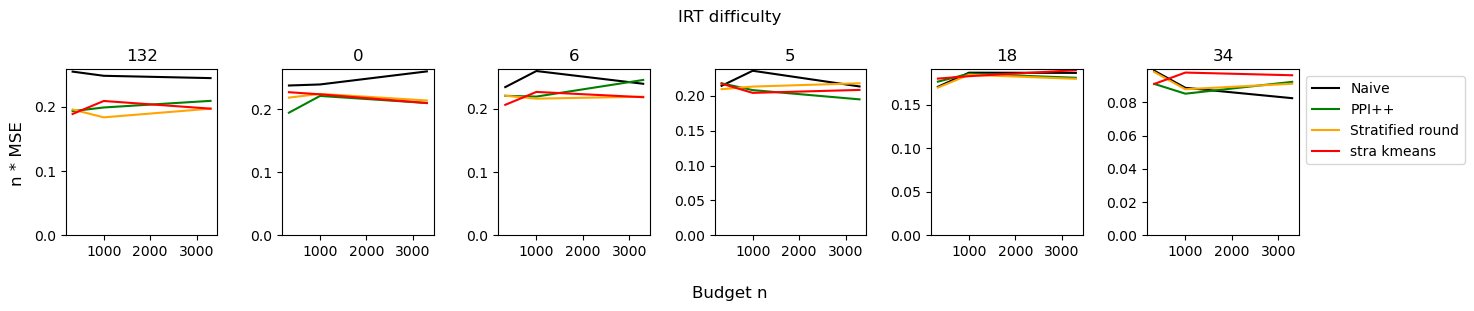

In [19]:
fig,axes = plt.subplots(1,6,figsize=(15,3))

models = [132,0,6,5,18,34] #Best to worse with roughly equally spaced models in between

for i,model in enumerate(models):
    f,y = make_predictions_irt_mmlu_pro(model)
    plot(f,y,axes[i],model,k=1000,ns=[330,1000,3300],strat=["kmeans_20"],adaptive = ["kmeans_20"],wr=True)
    f_processed = parse("kmeans_1000")(f)
    print(y.var(),var_strat(f_processed,y),var_adaptive_strat(f_processed,y))
    
plt.suptitle("IRT difficulty")    
plt.legend(["Naive","PPI++","Stratified round","stra kmeans","Adaptive round","adaptive kmeans"],bbox_to_anchor=(1,1))
fig.supxlabel("Budget n")
fig.supylabel("n * MSE")

fig.tight_layout()

plt.show()

0.11159607733456192 0.10308948384737462 0.09479262061044699
0.13417131558505752 0.12187497242776213 0.11288130351808791
0.14175047141725372 0.1294735717694336 0.12061857670532075
0.1677557921794873 0.14789666721408906 0.13872447902796783
0.2478506653519005 0.230363806644256 0.22983728923231628
0.1258845393946145 0.11503461881155817 0.10601270109668022


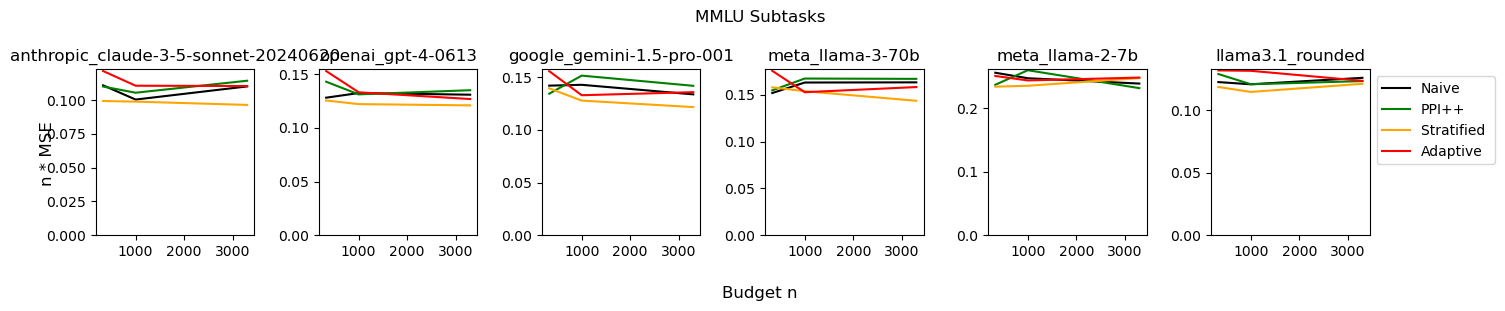

In [6]:
fig,axes = plt.subplots(1,6,figsize=(15,3))

models = ["anthropic_claude-3-5-sonnet-20240620","openai_gpt-4-0613","google_gemini-1.5-pro-001","meta_llama-3-70b","meta_llama-2-7b","llama3.1_rounded"]

for i,model in enumerate(models):
    f,y = make_predictions_subtasks(model)
    plot(f,y,axes[i],model,k=1000,ns=[330,1000,3300],strat=["id"],adaptive=["id"],wr=True)
    f_processed = f
    print(y.var(),var_strat(f_processed,y),var_adaptive_strat(f_processed,y))
    
    
plt.suptitle("MMLU Subtasks")    
plt.legend(["Naive","PPI++","Stratified ","Adaptive"],bbox_to_anchor=(1,1))
fig.supxlabel("Budget n")
fig.supylabel("n * MSE")

fig.tight_layout()

plt.show()

0.11159607733456192 0.11044335839658902 0.10950847753609404
0.13417131558505752 0.13239286280768864 0.131431853957233
0.14175047141725372 0.14026630442013416 0.13951496170054564
0.1677557921794873 0.16558600454280928 0.1650291891961107
0.2478506653519005 0.24694133051245498 0.2468246611029259
0.1258845393946145 0.12412371530577213 0.12310207983356859


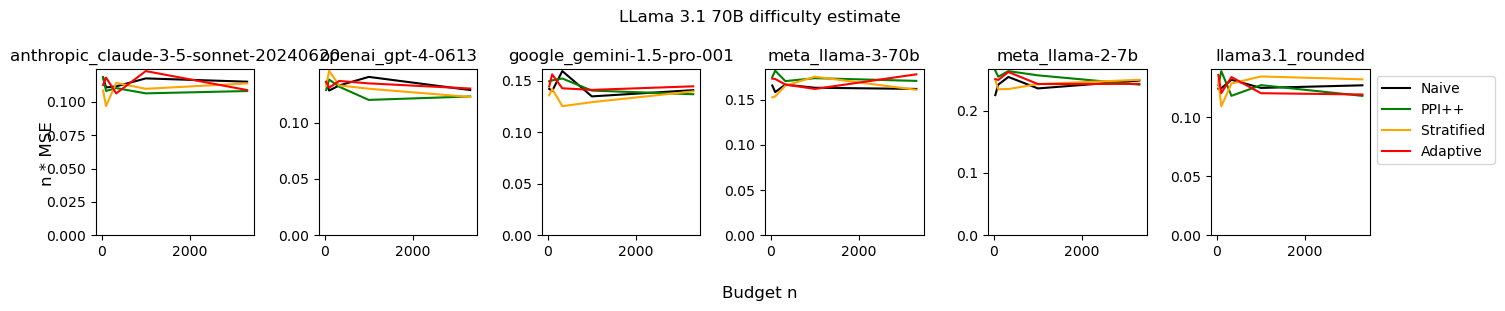

In [15]:
fig,axes = plt.subplots(1,6,figsize=(15,3))

models = ["anthropic_claude-3-5-sonnet-20240620","openai_gpt-4-0613","google_gemini-1.5-pro-001","meta_llama-3-70b","meta_llama-2-7b","llama3.1_rounded"]

for i,model in enumerate(models):
    f,y = make_predictions_difficulty(model)
    plot(f,y,axes[i],model,k=1000,ns=[33,100,330,1000,3300],strat=["kmeans_3"],adaptive=["kmeans_3"],wr=True)
    f_processed = parse("kmeans_7")(f)
    print(y.var(),var_strat(f_processed,y),var_adaptive_strat(f_processed,y))
    
plt.suptitle("LLama 3.1 70B difficulty estimate")    
plt.legend(["Naive","PPI++","Stratified ","Adaptive"],bbox_to_anchor=(1,1))
fig.supxlabel("Budget n")
fig.supylabel("n * MSE")

fig.tight_layout()

plt.show()

In [23]:
#Issues: IRT is dominated by around 2 strata?
#Difficulty estimates are crappy...

In [10]:
f,y=make_predictions_irt_mmlu_pro(0)

In [12]:
print(f[0:-1:100])

[-0.03258979  0.01438637  0.06354674  0.02086703  0.03193015 -0.09411312
 -0.05950696  0.01595112 -0.05912347  0.04907529 -0.00301908  0.01978939
  0.01866551  0.03361001  0.01146491 -0.02586711  0.04308879  0.00568349
 -0.04479055  0.04856414  0.01317941 -0.01599256 -0.06266207 -0.0438045
 -0.01131299  0.03175869  0.00140879  0.02567397  0.03651344  0.06967929
 -0.0683812   0.02599319 -0.01208592  0.08006424  0.00689561  0.01651031
  0.02181837  0.02024295  0.00033201  0.00861444 -0.06444638  0.058003
 -0.04843484 -0.00960856  0.03047041  0.01555898  0.06299839 -0.04394525
  0.00466906  0.07757492  0.03106512 -0.03200816  0.03148562  0.01065218
  0.02744672 -0.01264078  0.03535233  0.04623429 -0.03343095 -0.03829941
  0.09064969 -0.03027305  0.04888486 -0.01745546 -0.00482396 -0.01062672
  0.00766395 -0.01441783 -0.01044932  0.08099707  0.04000107  0.02630733
 -0.0428848  -0.00293477  0.04088253  0.06770289 -0.04255307  0.02901459
  0.00302493 -0.0692972  -0.00801188 -0.02201528  0.00

In [14]:
print(min(f))

-0.1345173865556717


In [21]:
print((parse("round_6")(f)==0.8).mean())

0.05975731382978723


In [22]:
from sklearn.cluster import KMeans

In [24]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit([[i] for i in f])

0.10455452127659574